# Perceptron
---

In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
import time
import random
from scipy.io import arff
from sklearn.metrics import accuracy_score

In [2]:
class LinBase(BaseEstimator, ClassifierMixin):
    def __init__(self, coef=None, intercept=None, class_labels=None):
        self.coef_ = coef
        self.intercept_ = intercept
        self.class_labels_ = class_labels
        
    def norm_(self, x):
        return np.sqrt(np.sum(np.square(x)))
    
    def margin(self, X, y):
        numerator = y * (X.dot(self.coef_) + self.intercept_)
        denominator = self.norm_(self.coef_)
        return numerator/denominator
    
    def decision_function(self, X):
        return self.margin(X, np.ones(X.shape[0]))
    
    def predict_proba(self, X):
        a, b = self.margin(X, np.ones((X.shape[0],)))
        return np.array([1 - 1/(1 + np.exp(-b)), 1 / (1 + np.exp(-b))]).T
    
    def predict(self, X):
        tic = time.time()
        results = np.sign(X.dot(self.coef_) + self.intercept_)
        results_mapped = self.class_labels_[1 * (results > 0)]
        print(f"Estimated time: {time.time() - tic}")
        return results_mapped
    
    def get_params(self, deep=True):
        pass
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    def __str__(self):
        return "{}[w={}, b={}]".format(self.__class__.__name__, self.coef_, self.intercept_)
    


In [3]:
class Perceptron(LinBase):
    def __init__(self, break_time=1, **kwargs):
        self.break_time_seconds_ = break_time * 3600
        LinBase.__init__(self, **kwargs)
        
    def fit(self, X, y):
        m, m1 = X.shape
        
        w = np.zeros(m1)
        b = 0
        tic = time.time()
        i = 0
        n = 0
        while (n < m) and ((time.time() - tic) < self.break_time_seconds_):
            if y[i] * (np.dot(w, X[i]) + b) <= 0:
                w = w + y[i] * X[i]
                b = b + y[i] * 1
                n = 0
            else:
                n+=1
            i = (i+1) % m
        
        self.coef_ = w
        self.intercept_ = b
        
        if time.time() - tic > self.break_time_seconds_:
            print(f"TIME LIMIT. DATA POSSIBLY NOT LINEARLY SEPARABLE")
        
        print(f"Estimated time: {time.time() - tic} seconds")
        
        

In [4]:
class PerceptronGamma(LinBase):
    def __init__(self, break_time=1, gamma=0.1, **kwargs):
        self.gamma_ = gamma
        self.break_time_seconds_ = break_time * 3600
        LinBase.__init__(self, **kwargs)
        
    def fit(self, X, y):
        m, m1 = X.shape
        
        w = np.zeros(m1)
        b = 0
        tic = time.time()
        i = 0
        n = 0
        while (n < m) and ((time.time() - tic) < self.break_time_seconds_):
            if y[i] * (np.dot(w, X[i]) + b) <= self.gamma_ * self.norm_(w):
                w = w + y[i] * X[i]
                b = b + y[i] * 1
                n = 0
            else:
                n+=1
            i = (i+1) % m
        
        self.coef_ = w
        self.intercept_ = b
        
        if time.time() - tic > self.break_time_seconds_:
            print(f"TIME LIMIT. DATA POSSIBLY NOT LINEARLY SEPARABLE")
            
        
        print(f"Estimated time: {time.time() - tic} seconds")
        
        

In [5]:
class VotedPerceptron(LinBase):
    def __init__(self, break_time=1, kmax=10000, max_iter=100000, **kwargs):
        self.kmax_ = kmax
        self.max_iter_ = max_iter
        self.break_time_seconds_ = break_time * 3600
        LinBase.__init__(self, **kwargs)
        self.c_ = None
        
    def fit(self, X, y):
        m, m1 = X.shape
        
        w = np.zeros((self.kmax_, m1))
        b = np.zeros(self.kmax_)
        c = np.zeros(self.kmax_)
        k = 0
        i = 0
        tic = time.time()
        counter = 0
        
        while (k < self.kmax_-1) and (counter < self.max_iter_) and ((time.time() - tic) < self.break_time_seconds_):
            if (y[i] * (np.dot(w[k], X[i]) + b[k])) <= 0:
                w[k+1] = w[k] + y[i] * X[i]
                b[k+1] = b[k] + y[i] * 1
                c[k] = 1
                k += 1
            else:
                c[k] += 1
            i = (i+1) % m
            counter += 1
            
        self.kmax_ = k
        self.coef_ = w[0:k, :]
        self.intercept_ = b[0:k]
        self.c_ = c
        
        print(f"{k=}, {counter=}")
        
        if time.time() - tic > self.break_time_seconds_:
            print(f"TIME LIMIT. DATA POSSIBLY NOT LINEARLY SEPARABLE")
            
        
        print(f"Estimated time: {time.time() - tic}")
        
    def predict(self, X):
        tic = time.time()
        results = []
        suma = 0
        for i in range(self.kmax_):
            suma += self.c_[i] * np.sign(X.dot(self.coef_[i]) + self.intercept_[i])
        results.append(np.sign(suma))
        results_mapped = self.class_labels_[1 * (np.array(results) > 0)]
        print(f"Estimated time: {time.time() - tic} seconds")
        return results_mapped.reshape(-1)
    
    def margin(self, X, y):
        numerator = y * (X.dot(self.coef_[-1]) + self.intercept_[-1])
        denominator = self.norm_(self.coef_)
        return numerator/denominator
        
        

In [6]:
class AveragedPerceptron(LinBase):
    def __init__(self, break_time=1, kmax=10000, max_iter=100000, **kwargs):
        self.kmax_ = kmax
        self.max_iter_ = max_iter
        self.break_time_seconds_ = break_time * 3600
        LinBase.__init__(self, **kwargs)
        self.c_ = None
        
    def fit(self, X, y):
        m, m1 = X.shape
        
        w = np.zeros((self.kmax_, m1))
        b = np.zeros(self.kmax_)
        c = np.zeros(self.kmax_)
        k = 0
        i = 0
        tic = time.time()
        counter = 0
        
        while (k < self.kmax_-1) and (counter < self.max_iter_) and ((time.time() - tic) < self.break_time_seconds_):
            if (y[i] * (np.dot(w[k], X[i]) + b[k])) <= 0:
                w[k+1] = w[k] + y[i] * X[i]
                b[k+1] = b[k] + y[i] * 1
                c[k] = 1
                k += 1
            else:
                c[k] += 1
            i = (i+1) % m
            counter += 1
            
        self.kmax_ = k
        self.coef_ = w[0:k, :]
        self.intercept_ = b[0:k]
        self.c_ = c
        
        print(f"{k=}, {counter=}")
        
        if time.time() - tic > self.break_time_seconds_:
            print(f"TIME LIMIT. DATA POSSIBLY NOT LINEARLY SEPARABLE")
            
        
        print(f"Estimated time: {time.time() - tic}")
        
    def predict(self, X):
        tic = time.time()
        results = []
        suma = 0
        for i in range(self.kmax_):
            suma += self.c_[i] * X.dot(self.coef_[i]) + self.intercept_[i]
        results.append(np.sign(suma))
        results_mapped = self.class_labels_[1 * (np.array(results) > 0)]
        print(f"Estimated time: {time.time() - tic} seconds")
        return results_mapped.reshape(-1)
    
    def margin(self, X, y):
        numerator = y * (X.dot(self.coef_[-1]) + self.intercept_[-1])
        denominator = self.norm_(self.coef_)
        return numerator/denominator
        
        

In [7]:
def plotDecision(X, y, clf):
    grid = 100
    X1, X2 = np.meshgrid(np.linspace(np.min(X), np.max(X), grid), np.linspace(np.min(X), np.max(X), grid))
    pred = clf.predict(np.array([X1.ravel(), X2.ravel()]).T)
    pred = np.reshape(pred, (grid, grid))
    plt.contour(X1, X2, pred, 1)
    
    indexes = y==1
    plt.scatter(X[indexes, 0], X[indexes, 1], label="1", marker="^")
    plt.scatter(X[np.logical_not(indexes), 0], X[np.logical_not(indexes), 1], label="-1", marker="s")
    plt.show()



# Artificial data

## Generation of separable data

In [8]:
m, n = 50, 2
X = np.random.rand(m, n)
y = (X.dot([1,1])>1) * 2 -1

## Simple perceptron

In [9]:
simple_perceptron = Perceptron(1, class_labels=np.unique(y))

In [10]:
simple_perceptron.fit(X, y)

Estimated time: 0.014002323150634766 seconds


In [11]:
y

array([ 1,  1,  1,  1, -1, -1,  1, -1,  1, -1, -1, -1, -1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1, -1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  1, -1, -1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1,  1])

In [12]:
y_pred = simple_perceptron.predict(X)

Estimated time: 0.0


### Margin

In [13]:
np.min(simple_perceptron.margin(X, y))

0.0074690468264184675

### Accuracy score

In [14]:
accuracy_score(y, y_pred)

1.0

Estimated time: 0.0


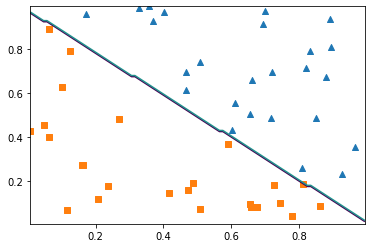

In [15]:
plotDecision(X, y, simple_perceptron)

## Gamma Perceptron

In [16]:
gamma_perceptron = PerceptronGamma(1, gamma=0.0001, class_labels=np.unique(y))

In [17]:
gamma_perceptron.fit(X, y)

Estimated time: 0.028902053833007812 seconds


In [18]:
y

array([ 1,  1,  1,  1, -1, -1,  1, -1,  1, -1, -1, -1, -1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1, -1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  1, -1, -1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1,  1])

In [19]:
y_pred = gamma_perceptron.predict(X)

Estimated time: 0.0


### Margin

In [20]:
np.min(gamma_perceptron.margin(X, y))

0.0074690468264184675

### Accuracy score

In [21]:
accuracy_score(y, y_pred)

1.0

Estimated time: 0.001994609832763672


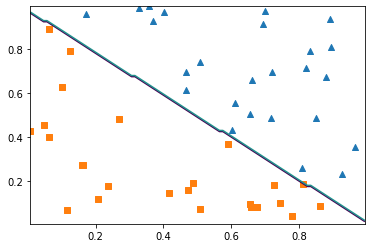

In [22]:
plotDecision(X, y, gamma_perceptron)

## Voting Perceptron

In [23]:
voted_perceptron = VotedPerceptron(1, kmax=1000, max_iter=1000, class_labels=np.unique(y))

In [24]:
voted_perceptron.fit(X, y)

k=113, counter=1000
Estimated time: 0.010983705520629883


In [25]:
y

array([ 1,  1,  1,  1, -1, -1,  1, -1,  1, -1, -1, -1, -1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1, -1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  1, -1, -1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1,  1])

In [26]:
y_pred = voted_perceptron.predict(X)

Estimated time: 0.0009953975677490234 seconds


Estimated time: 0.022293806076049805 seconds


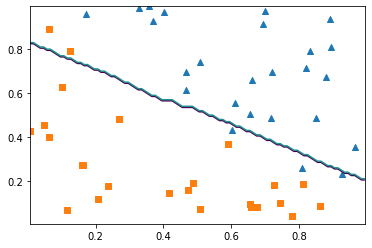

In [27]:
plotDecision(X, y, voted_perceptron)

### Margin

In [28]:
np.min(voted_perceptron.margin(X, y))

-0.024633708430923332

### Accuracy score

In [29]:
accuracy_score(y, y_pred)

0.9

## Averaged perceptron

In [30]:
averaged_perceptron = AveragedPerceptron(1, kmax=1000, max_iter=1000, class_labels=np.unique(y))

In [31]:
averaged_perceptron.fit(X, y)

k=113, counter=1000
Estimated time: 0.01396036148071289


In [32]:
y

array([ 1,  1,  1,  1, -1, -1,  1, -1,  1, -1, -1, -1, -1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1, -1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  1, -1, -1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1,  1])

In [33]:
y_pred = averaged_perceptron.predict(X)

Estimated time: 0.0029904842376708984 seconds


### Margines

In [34]:
np.min(averaged_perceptron.margin(X, y))

-0.024633708430923332

### Accuracy score

In [35]:
accuracy_score(y, y_pred)

0.92

Estimated time: 0.016973018646240234 seconds


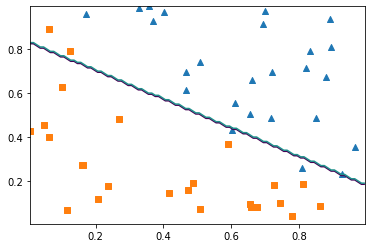

In [36]:
plotDecision(X, y, averaged_perceptron)

# Sonar dataset

In [37]:
def fun(x):
    if type(x) == bytes:
        return str(x, encoding="utf-8")
    else:
        return x

In [38]:
data, meta = arff.loadarff("sonar.arff")
df = pd.DataFrame(data).applymap(fun).dropna()

In [39]:
df

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,...,attribute_52,attribute_53,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60,Class
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,Rock
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,Rock
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,Rock
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,Rock
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,Rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.0187,0.0346,0.0168,0.0177,0.0393,0.1630,0.2028,0.1694,0.2328,0.2684,...,0.0116,0.0098,0.0199,0.0033,0.0101,0.0065,0.0115,0.0193,0.0157,Mine
204,0.0323,0.0101,0.0298,0.0564,0.0760,0.0958,0.0990,0.1018,0.1030,0.2154,...,0.0061,0.0093,0.0135,0.0063,0.0063,0.0034,0.0032,0.0062,0.0067,Mine
205,0.0522,0.0437,0.0180,0.0292,0.0351,0.1171,0.1257,0.1178,0.1258,0.2529,...,0.0160,0.0029,0.0051,0.0062,0.0089,0.0140,0.0138,0.0077,0.0031,Mine
206,0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,0.2354,...,0.0086,0.0046,0.0126,0.0036,0.0035,0.0034,0.0079,0.0036,0.0048,Mine


In [40]:
X = df.iloc[:, 0:-1].to_numpy()

In [41]:
df.loc[df.Class == "Rock", "Class"] = -1
df.loc[df.Class == "Mine", "Class"] = 1
y = np.array(df.iloc[:, -1].to_list())

## Simple perceptron

In [42]:
simple_perceptron = Perceptron(1, class_labels=np.unique(y))

In [43]:
simple_perceptron.fit(X, y)

Estimated time: 309.07674908638 seconds


In [44]:
y

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1])

In [45]:
y_pred = simple_perceptron.predict(X)

Estimated time: 0.0


### Margin

In [46]:
np.min(simple_perceptron.margin(X, y))

3.5167869849148566e-05

### Accuracy score

In [47]:
accuracy_score(y, y_pred)

1.0

## Gamma Perceptron

In [48]:
gamma_perceptron = PerceptronGamma(1, gamma=0.0001, class_labels=np.unique(y))

In [49]:
gamma_perceptron.fit(X, y)

Estimated time: 883.0951335430145 seconds


In [50]:
y

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1])

In [51]:
y_pred = gamma_perceptron.predict(X)

Estimated time: 0.0009818077087402344


In [52]:
np.min(gamma_perceptron.margin(X, y))

0.00010183683929027797

### Margin

In [53]:
np.min(gamma_perceptron.margin(X, y))

0.00010183683929027797

### Accuracy score

In [54]:
accuracy_score(y, y_pred)

1.0

## Voting perceptron

In [55]:
voted_perceptron = VotedPerceptron(1, kmax=10000000, max_iter=100000000, class_labels=np.unique(y))

In [56]:
voted_perceptron.fit(X, y)

k=2729231, counter=100000000
Estimated time: 690.7259919643402


In [57]:
y

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1])

In [58]:
y_pred = voted_perceptron.predict(X)

Estimated time: 201.41563296318054 seconds


### Margin

In [59]:
np.min(voted_perceptron.margin(X, y))

-1.6396034125688079e-06

### Accuracy score

In [60]:
accuracy_score(y, y_pred)

0.8942307692307693

## Averaged perceptron

In [61]:
averaged_perceptron = AveragedPerceptron(1, kmax=10000000, max_iter=100000000, class_labels=np.unique(y))

In [62]:
averaged_perceptron.fit(X, y)

k=2729231, counter=100000000
Estimated time: 674.9055290222168


In [63]:
y

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1])

In [64]:
y_pred = averaged_perceptron.predict(X)

Estimated time: 202.9735312461853 seconds


### Margin

In [65]:
np.min(averaged_perceptron.margin(X, y))

-1.6396034125688079e-06

### Accuracy score

In [66]:
accuracy_score(y, y_pred)

0.8846153846153846